## Name: Abhishek Ghosh
## Roll No: ME21BTECH11001

# Problem 1: Given two arbitrary locations on the earth's surface, find the range of velocity vectors with which a projectile needs to be launched to transport it from one location to another. Ignore atmospheric drag effects for this problem.

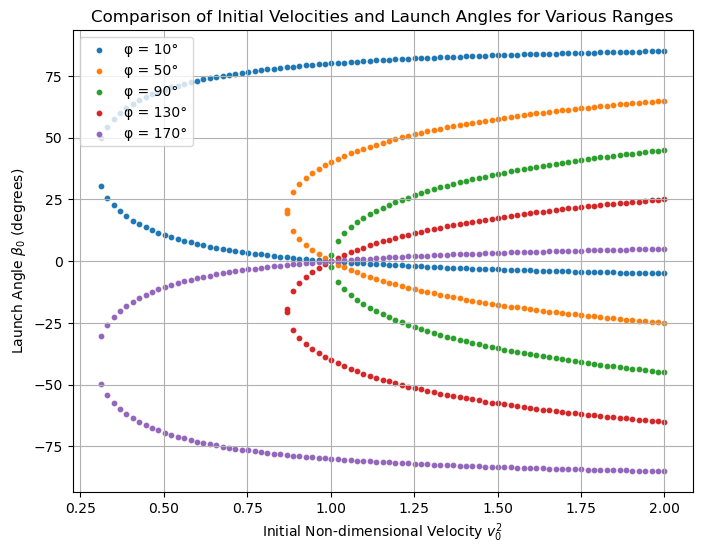

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
R_E = 6371e3  # Earth's radius in meters
mu = 3.986e14  # Earth's gravitational parameter in m^3/s^2

# Function to compute launch angle beta_0 for given velocity and semirange angle
def compute_beta0(v0_squared, phi):
    term = v0_squared**2 - 4 * (1 - v0_squared) * np.tan(phi)**2
    if term < 0:
        return None  # No valid solution
    beta1 = np.arctan((v0_squared + np.sqrt(term)) / (2 * np.tan(phi)))
    beta2 = np.arctan((v0_squared - np.sqrt(term)) / (2 * np.tan(phi)))
    return np.degrees(beta1), np.degrees(beta2)  # Convert to degrees

# Define velocity range (normalized to Earth's circular velocity)
v0_squared_vals = np.linspace(0.1, 2, 100)  # From 0.1 to 2

# Define semirange angles in degrees
phi_vals = np.radians(np.linspace(10, 170, 5))  # Convert degrees to radians

# Plot setup
plt.figure(figsize=(8, 6))

for phi in phi_vals:
    beta_angles = []
    v0_vals = []
    # max_range_angle = 90 - np.degrees(phi) / 2  # Maximum range launch angle

    for v0_squared in v0_squared_vals:
        result = compute_beta0(v0_squared, phi)
        if result:
            beta1, beta2 = result
            beta_angles.append(beta1)
            v0_vals.append(v0_squared)
            if beta2 != beta1:  # If two solutions exist
                beta_angles.append(beta2)
                v0_vals.append(v0_squared)

    plt.scatter(v0_vals, beta_angles, label=f'φ = {np.degrees(phi):.0f}°', s=10)  # Scatter plot
    # plt.axhline(max_range_angle, linestyle='--', color='black', alpha=0.5)  # Max range angle

# Formatting the plot
plt.xlabel('Initial Non-dimensional Velocity $v_0^2$')
plt.ylabel('Launch Angle $\\beta_0$ (degrees)')
plt.title('Comparison of Initial Velocities and Launch Angles for Various Ranges')
plt.legend()
plt.grid()
plt.show()


# Problem 2. Control of pendulum on a cart. 

In [3]:
%reset -f

# Inverted pendulum on a cart


$\dot{x} = v$  
$\dot{x} = \frac{-m^2L^2 g cos(\theta)sin(\theta) + mL^2(mL\omega^2 \omega^2sin(\theta)-\delta v) +mL^2u}{mL^2(M+m(1-cos(\theta)^2))}$  
$\dot{\theta} = \omega$  
$\dot{\theta} = \frac{(m+M)mgLsin(\theta) - mLcos(\theta)(mL\omega^2sin(\theta)-\delta v) + mLcos(\theta)u}{mL^2(M+m(1-cos(\theta)^2))}$
\\

This dynamics can be linarized into:  
$
\frac{d}{dt} \begin{bmatrix}
x_1\\
x_2\\
x_3\\
x_4
\end{bmatrix} = 
\begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & -\frac{\omega}{M} & b\frac{mg}{M} & 0\\
0 & 0 & 0 & 1\\
0 & -b\frac{\delta}{ML} & -b\frac{(m + M)g}{ML} & 0
\end{bmatrix}
\begin{bmatrix}
x_1\\
x_2\\
x_3\\
x_4
\end{bmatrix}
+
\begin{bmatrix}
0\\
\frac{1}{M}\\
0\\
b\frac{1}{ML}
\end{bmatrix}
u
$,  
Where $m$ is pendulum mass, $M$ cart mass, $L$ pendulum length, $g$ gravitational acceleration, and $\delta$ cart damping. This system then represents matrix system:

$$\frac{dx}{dt} = Ax + Bu$$

In [4]:
import control
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

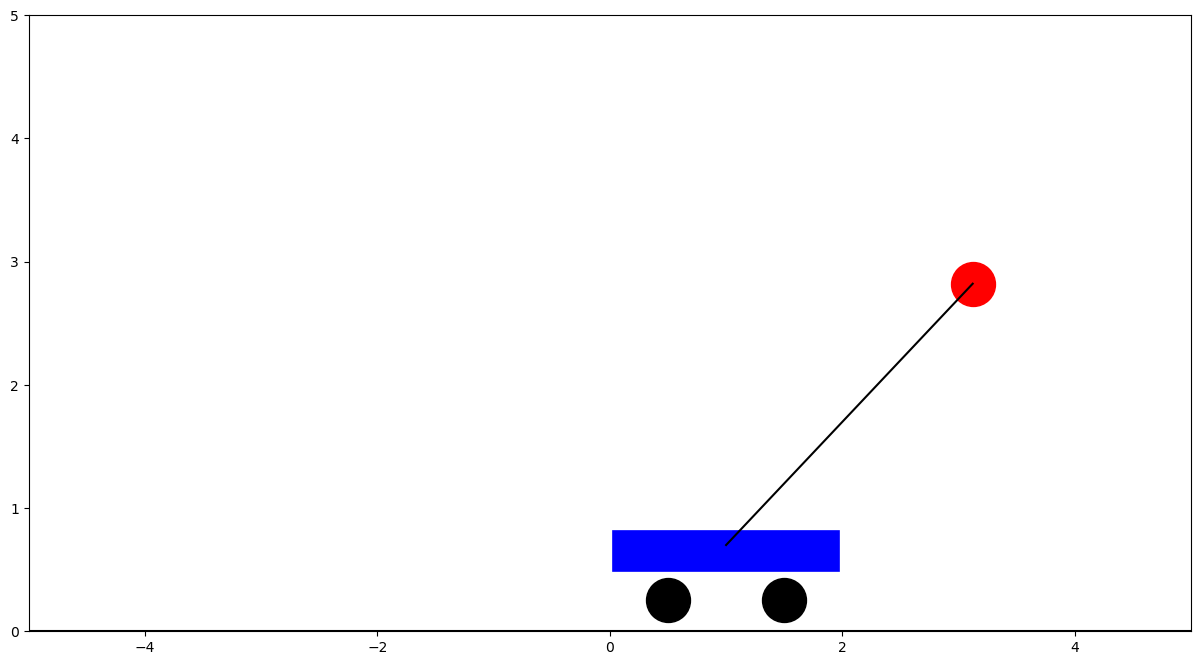

In [17]:
def draw_cart(position=0, angle=np.pi, index=-1):
    plt.figure(figsize=(15, 8))
    plt.xlim(-5, 5)
    plt.ylim(0, 5)
    plt.scatter(-.5 + position, .25, s=1000, c="k")  # left wheel
    plt.scatter(.5 + position, .25, s=1000, c="k")  # right wheel
    plt.plot([-5, 5], [0, 0], "k-")  # x axis
    plt.plot([-.8 + position, .8 + position], [.65, .65], "b-", linewidth=30)  # cart body
    plt.plot([0 + position, -3 * np.sin(-angle) + position], [0.7, -3 * np.cos(-angle) + .7], "k-")  # pendulum arm
    plt.scatter(-3 * np.sin(-angle) + position, -3 * np.cos(-angle) + .7, s=1000, c="r")  # pendulum
    if index < 0:
        plt.show()
    else:
        plt.savefig(f"img/img_{index}.png", dpi=120, bbox_inches="tight")
    

draw_cart(1, 3 * np.pi / 4)

# Fixed conditions
# theta = 0 and pi
# theta dot =0 and x dot =0, x = free

In [18]:
def compute_a_matrix(mass_pend=1, mass_cart=5, length_arm=2, gravity=-10, damping=1, factor=1):
    return np.array([
        [0, 1, 0, 0],
        [0, -damping / mass_cart, factor * mass_pend * gravity / mass_cart, 0],
        [0, 0, 0, 1],
        [0, -factor * damping / (mass_cart * length_arm), -factor * (mass_pend + mass_cart) * gravity / (mass_cart * length_arm), 0]
    ])

def compute_b_matrix(mass_pend=1, mass_cart=5, length_arm=2, gravity=-10, damping=1, factor=1):
    return np.array([[0, 1 / mass_cart, 0, factor / (mass_cart * length_arm)]]).T

A = compute_a_matrix()
B = compute_b_matrix()
n_dim = compute_a_matrix().shape[0]

control_matrix = control.ctrb(A, B)
rank = np.linalg.matrix_rank(control_matrix)
print(f"Eigen values of matrix A: {list(np.linalg.eig(A)[0])}")
print(f"Rank of the control matrix: rank={rank} (if rank={n_dim} it is controllable)")

Eigen values of matrix A: [0.0, -2.4311230004720983, -0.23363938083350477, 2.464762381305604]
Rank of the control matrix: rank=4 (if rank=4 it is controllable)


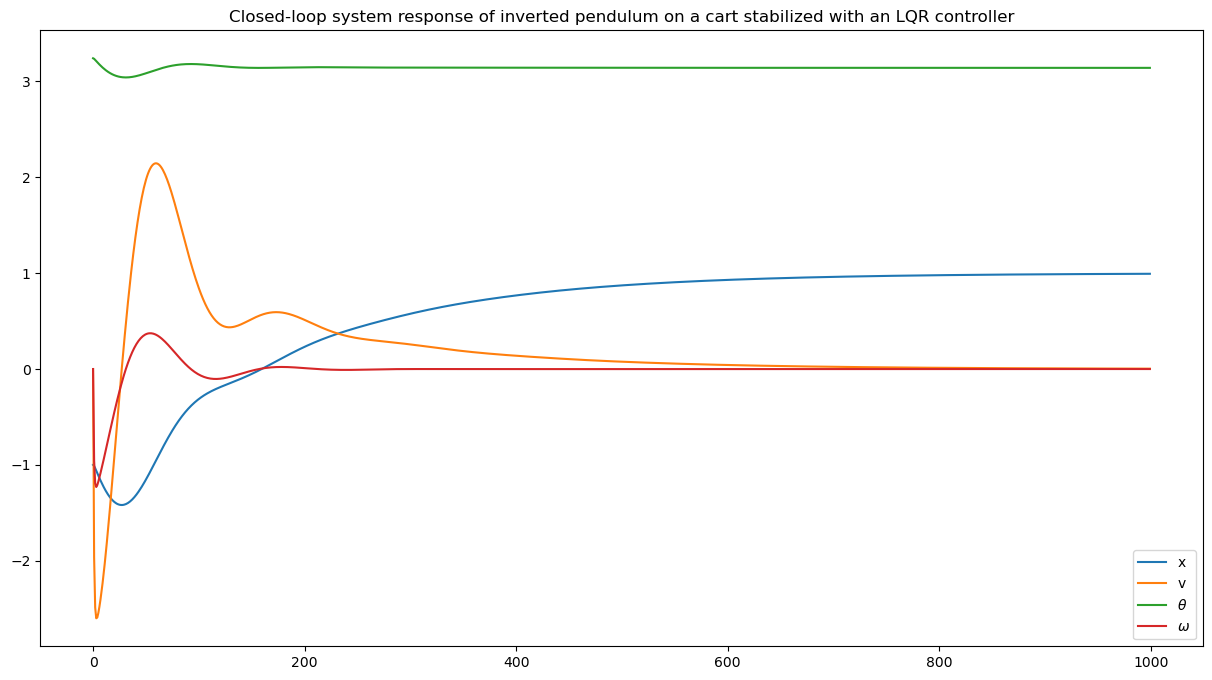

In [19]:
# Design LQR controller
# Q is penalty on x vector, R is penalty on u => J is cost matrix including Q and R
# J is a quadratic Cost function minimized by Linear Controller u=-kx =>LQR will give K matrix O(n^3) but not good for big systems
Q = np.eye(4)   # np.diag(np.array([1, 1, 10, 100]))
R = .0001
K, S, E = control.lqr(A, B, Q, R)

def pendulum_cart(state, time, mass_pend=1, mass_cart=5, length_arm=2, gravity=-10, damping=1, scale=1):
    sine_theta = np.sin(state[2])
    cosine_theta = np.cos(state[2])
    denominator = mass_pend * (length_arm ** 2) * (mass_pend + mass_cart * (1 - cosine_theta ** 2))
    
    ref_state = np.array([1, 0, np.pi, 0])
    
    control_input = np.dot(-K, (state - ref_state))[0]
    return np.array([
        state[1],
        (1/denominator)*(-(mass_pend**2)*(length_arm**2)*gravity*cosine_theta*sine_theta + mass_pend*(length_arm**2)*(mass_pend*length_arm*(state[3]**2)*sine_theta - damping*state[1])) + mass_pend*(length_arm**2)*(1/denominator)*control_input,
        state[3],
        (1/denominator)*((mass_pend+mass_cart)*mass_pend*gravity*length_arm*sine_theta - mass_pend*length_arm*cosine_theta*(mass_pend*length_arm*(state[3]**2)*sine_theta - damping*state[1])) - mass_pend*length_arm*cosine_theta*(1/denominator)*control_input
    ])

time_vector = np.arange(0, 10, 0.01)
initial_state = np.array([-1, 0, np.pi + .1, 0])

solution = odeint(pendulum_cart, initial_state, time_vector)

plt.figure(figsize=(15, 8))
plt.title("Closed-loop system response of inverted pendulum on a cart stabilized with an LQR controller")
plt.plot(solution, label=["x", "v", r"$\theta$", r"$\omega$"])
plt.legend()
plt.show()

Initial conditions:   
$x_0 = [-1, 0, \pi +  0.1, 0]^T$  
Actuation:   
$u = -K(x - w_r)$  
The reference position:  
$w_r = [1, 0, \pi, 0]^T$

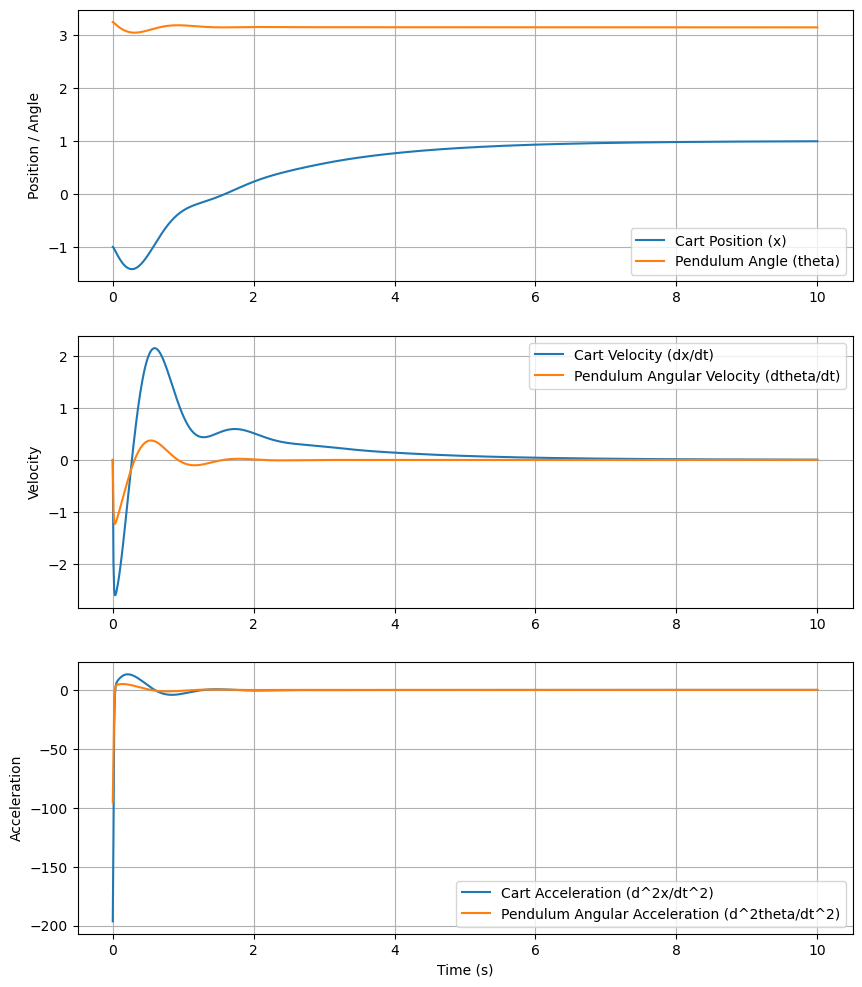

In [20]:
# Extract and plot velocity and acceleration
time_vector = np.linspace(0, 10, len(solution))

velocity_x = solution[:, 1]  # Cart velocity
velocity_theta = solution[:, 3]  # Pendulum angular velocity

acceleration_x = np.gradient(velocity_x, time_vector)
acceleration_theta = np.gradient(velocity_theta, time_vector)

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

axs[0].plot(time_vector, solution[:, 0], label='Cart Position (x)')
axs[0].plot(time_vector, solution[:, 2], label='Pendulum Angle (theta)')
axs[0].set_ylabel("Position / Angle")
axs[0].legend()
axs[0].grid()

axs[1].plot(time_vector, velocity_x, label='Cart Velocity (dx/dt)')
axs[1].plot(time_vector, velocity_theta, label='Pendulum Angular Velocity (dtheta/dt)')
axs[1].set_ylabel("Velocity")
axs[1].legend()
axs[1].grid()

axs[2].plot(time_vector, acceleration_x, label='Cart Acceleration (d^2x/dt^2)')
axs[2].plot(time_vector, acceleration_theta, label='Pendulum Angular Acceleration (d^2theta/dt^2)')
axs[2].set_ylabel("Acceleration")
axs[2].set_xlabel("Time (s)")
axs[2].legend()
axs[2].grid()

plt.show()

## References
[1] Brunton, S., & Kutz, J. (2019). _Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control._ Cambridge: Cambridge University Press. doi:10.1017/9781108380690  
[2] Brunton, S, (2017). _Linear Quadratic Regulator (LQR) Control for the Inverted Pendulum on a Cart [Control Bootcamp]_, https://www.youtube.com/watch?v=1_UobILf3cc  

# Problem 3. A ball being launched from a spinning massless tube. Refer Problem 2.4 from Schaub and Junkins, 4th edition. Find the initial conditions (Theta and Omega) to ensure that the ball enters a specific a hole on the ground after being pushed out of the pipe.

Optimal Initial Conditions: Theta = 35.85 degrees, Omega = 5.00 rad/s


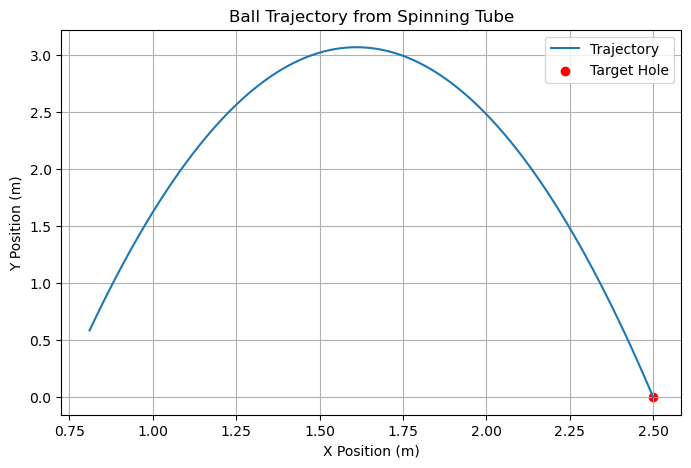

In [22]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def projectile_motion(theta, omega, L, v, g, x_h, y_h):
    theta = np.radians(theta)
    
    # Initial position
    x0, y0 = L * np.cos(theta), L * np.sin(theta)
    
    # Initial velocity components
    v_x = v * np.cos(theta) - L * omega * np.sin(theta)
    v_y = v * np.sin(theta) + L * omega * np.cos(theta)
    
    # Solve for time of flight using quadratic equation
    a = -0.5 * g
    b = v_y
    c = y0 - y_h
    
    t_flight = np.roots([a, b, c])
    t_flight = t_flight[t_flight > 0]  # Take the positive root
    if len(t_flight) == 0:
        return np.inf  # No valid solution
    t_flight = t_flight[0]
    
    # Compute x position at time t_flight
    x_final = x0 + v_x * t_flight
    return x_final - x_h  # Should be zero for a correct solution

def find_initial_conditions(L, v, g, x_h, y_h):
    def equations(vars):
        theta, omega = vars
        return projectile_motion(theta, omega, L, v, g, x_h, y_h), omega - 5  # Initial guess constraint
    
    theta_omega_sol = fsolve(equations, [45, 5])
    return theta_omega_sol

def plot_trajectory(theta, omega, L, v, g, x_h, y_h):
    theta = np.radians(theta)
    x0, y0 = L * np.cos(theta), L * np.sin(theta)
    v_x = v * np.cos(theta) - L * omega * np.sin(theta)
    v_y = v * np.sin(theta) + L * omega * np.cos(theta)
    
    t_flight = max(np.roots([-0.5 * g, v_y, y0]))
    t_vals = np.linspace(0, t_flight, 100)
    x_vals = x0 + v_x * t_vals
    y_vals = y0 + v_y * t_vals - 0.5 * g * t_vals**2
    
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, y_vals, label="Trajectory")
    plt.scatter([x_h], [y_h], color='red', label="Target Hole")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.legend()
    plt.title("Ball Trajectory from Spinning Tube")
    plt.grid()
    plt.show()

# Parameters
L = 1.0  # Tube length (m)
v = 5.0  # Exit speed (m/s)
g = 9.81 # Gravity (m/s^2)
x_h, y_h = 2.5, 0  # Target hole position

theta, omega = find_initial_conditions(L, v, g, x_h, y_h)
print(f"Optimal Initial Conditions: Theta = {theta:.2f} degrees, Omega = {omega:.2f} rad/s")
plot_trajectory(theta, omega, L, v, g, x_h, y_h)
